In [7]:
###
#Demo analysis of the clustering package.
#Within the package, the following algorithms have been implemented:
#
#        - Standard K-Means (KM): 
#            Subcase of KKM with a linear kernel.
#        
#        - Kernel k-Means (KKM): 
#            Clusters in feature space.          
#        
#        - Global Kernel k-Means (GKKM): 
#            kKM with a local search to define initial cluster positions.
#            
#        - Global Kernel k-Means with Convex Mixture Models (GKKM-CMM):
#            optimized boosted version of GkKM to reduce complexity.
#            
#        - Adaptive Weights Clustering (AWC): 
#            A type of adaptive nonparametric clustering.	    
#            
#The present demo evaluates the algorithms performance on the
#Shape sets and the UCI datasets lists on the Clustering benchmark datasets page:
#    
#        - https://cs.joensuu.fi/sipu/datasets/
#
###

# Author: Francesco Casola <fr.casola@gmail.com>

In [13]:
# importing the clustering package (personal one) 
import sys
path_pc = r"../"
sys.path.append(path_pc)
# importing personal package
import clustering as cl

In [19]:
# importing pandas and other modules to handle datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
# os functionalities
import os
#evaluate NMI using the definition in the Efimov paper
from sklearn.metrics import normalized_mutual_info_score as NMI

In [15]:
###
#PART I: The Shape Set
#
#n_samples: from 240 to 3100
#n_features: 2
#n_clusters: from 2 to 31
###

In [16]:
#1 - Loading dataset
path = r"../data/Shape_Set"
#dictionary of a set of dataframes
set_dataframes = {}
#gathering and loading fles
for fname in os.listdir(path):
    if fname.endswith('.txt'):
        local_fname = os.path.join(path,fname).replace("\\","/")
        set_dataframes[fname.strip('.txt')] = pd.read_csv(local_fname,delimiter='\t', lineterminator='\n', \
                                           names = ["X", "Y", "Labels"])

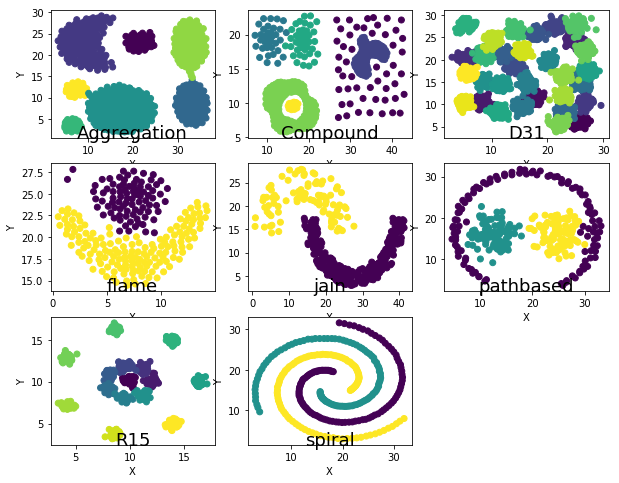

In [20]:
#2 - plotting dataset
#dataset names
dts_names = list(set_dataframes.keys())
#dataset size
dt_size = len(dts_names)
#approximating to nearest bigger square
perf_sq = np.arange(1,100)
id_plots = np.where(perf_sq**2>=dt_size)[0]
n_plots = perf_sq[id_plots[0]]

#making the plot
plt.figure(num=1,figsize=(10,8))
for i in range(1, n_plots**2):
    plt.subplot(n_plots, n_plots, i) 
    ax = plt.scatter(set_dataframes[dts_names[i-1]]["X"], \
                 set_dataframes[dts_names[i-1]]["Y"], \
                 c=set_dataframes[dts_names[i-1]]["Labels"])
    loc_ax = np.array(plt.axis())
    plt.text(np.mean(loc_ax[:2]),loc_ax[2], dts_names[i-1],
             fontsize=18, ha='center')    
    plt.xlabel("X")
    plt.ylabel("Y")

In [21]:
#3- running partitional algorithms and using evaluation metrics
# Elbow plots will be generated with and without data normalization for 3 selected datasets

In [26]:
%%capture
#do not show irrelevant output of the calculation

#3a - Kernel k-Means (KKM)
# we perform a first analysis on 3 selected datasets: 'Aggregation','Compound','pathbased'
# running the algorithm on:
# - different number of initial clusters
# - different values for the kernel variance (sigma)

#run KKM with and without data normalization
#initializing lists of fitted datasets
KKM_no_norm_labels = {}
KKM_norm_labels = {}
sigma_val_no_norm = [1,3,5,7]
sigma_val_norm = [0.05,0.2,0.3,0.5]
#let's select a subset for this first plot
dts_names_selected = ['Aggregation','Compound','pathbased']

print("KKM algorithm.")
for i in dts_names_selected:
    #starting the loop
    print("Considering the %s dataset"%i)
    #initializing datasets
    KKM_no_norm_labels[i] = []
    KKM_norm_labels[i] = []
    #getting the dataset: NO normalization
    XX = set_dataframes[i].as_matrix(columns=["X","Y"])
    #getting the dataset: normalized
    XX_norm = (XX - XX.mean(axis=0))/(XX.std(axis=0)+sys.float_info.epsilon)    
    
    for sigma in range(len(sigma_val_no_norm)):    
        print("Kernel variance %3.2f (non-norm.), %3.2f (norm.)"%(sigma_val_no_norm[sigma],sigma_val_norm[sigma]))
        #initialize the classes
        KKM_means = cl.Cluster_class(algorithm="KKM",verbose=0, \
                                     sigm_gauss=sigma_val_no_norm[sigma])
        KKM_means_norm = cl.Cluster_class(algorithm="KKM",verbose=0, \
                                          sigm_gauss=sigma_val_norm[sigma])
        #starting the clustering: NO normalization
        print("Non-normalized dataset")
        KKM_means.fit(XX)
        #save
        KKM_no_norm_labels[i].append([KKM_means.labels_,KKM_means.cluster_error_])
        #starting the clustering: normalized
        print("Normalized dataset")
        KKM_means_norm.fit(XX_norm)
        #save    
        KKM_norm_labels[i].append([KKM_means_norm.labels_,KKM_means_norm.cluster_error_])

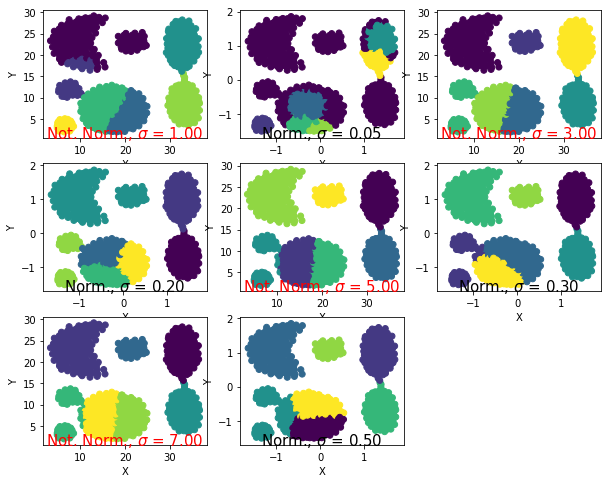

In [27]:
#3b - example plot of the results in 3a ofor the "Aggregation" dataset.
# we plot here the result for 7 initial clusters given. The elbow plot 
# for the three selected sets is shown in the next cell.

#dataset name
dataset_nm = "Aggregation"
#select a solution for this number of initial clusters
n_clus_sel = 7
#making the plot
plt.figure(num=2,figsize=(10,8))
for i in range(0, 4):
    #getting the dataset: NO normalization
    XX = set_dataframes[dataset_nm].as_matrix(columns=["X","Y"])
    label_loc = KKM_no_norm_labels[dataset_nm][i][0][n_clus_sel]
    #getting the dataset: normalized
    XX_norm = (XX - XX.mean(axis=0))/(XX.std(axis=0)+sys.float_info.epsilon)    
    label_loc_norm = KKM_norm_labels[dataset_nm][i][0][n_clus_sel]
    #plot
    plt.subplot(n_plots, n_plots, 2*i+1) 
    ax = plt.scatter(XX[:,0],XX[:,1],c=label_loc)
    loc_ax = np.array(plt.axis())
    plt.text(np.mean(loc_ax[:2]),loc_ax[2], 'Not. Norm., $\sigma$ = %3.2f'%sigma_val_no_norm[i],
             color='red',fontsize=15, ha='center')    
    plt.xlabel("X")
    plt.ylabel("Y")
    #plot
    plt.subplot(n_plots, n_plots, 2*(i+1)) 
    ax = plt.scatter(XX_norm[:,0],XX_norm[:,1],c=label_loc_norm)
    loc_ax = np.array(plt.axis())
    plt.text(np.mean(loc_ax[:2]),loc_ax[2], 'Norm., $\sigma$ = %3.2f'%sigma_val_norm[i],
             fontsize=15, ha='center')    
    plt.xlabel("X")
    plt.ylabel("Y")

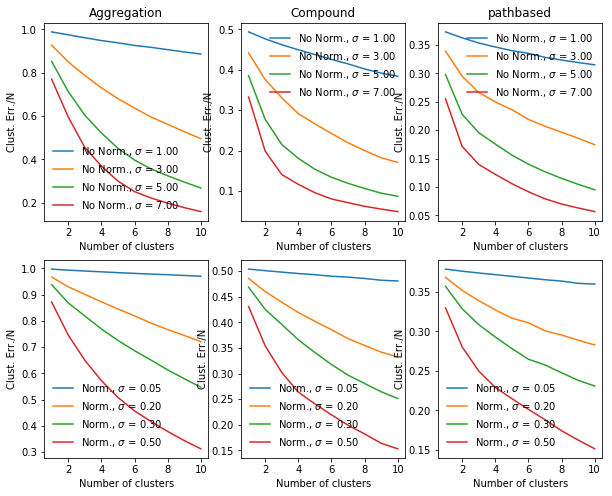

In [32]:
#3c - We now produce an exemplary Elbow plot running over the hyperparameters and
# the 3 selected datasets. We evaluate the cluster error per point in the dataset.

# maximum number of clusters used to produce the elbow plot
n_clusters = len(KKM_norm_labels[dataset_nm][0][0].keys())
    
Elbow_plot_no_norm = {}
Elbow_plot_norm = {}

#gathering data
for nm in dts_names_selected:
    clutser_err_no_norm = np.zeros((len(sigma_val_no_norm),n_clusters))
    clutser_err_norm = np.zeros((len(sigma_val_norm),n_clusters))
    for sgm in range(len(sigma_val_no_norm)):
        for ncl in range(n_clusters):
            clutser_err_no_norm[sgm,ncl] = KKM_no_norm_labels[nm][sgm][1][ncl+1][0]
            clutser_err_norm[sgm,ncl] = KKM_norm_labels[nm][sgm][1][ncl+1][0]
    Elbow_plot_no_norm[nm] = clutser_err_no_norm
    Elbow_plot_norm[nm] = clutser_err_norm
    
#Producing the elbow plot!
dim_subset = len(dts_names_selected)
x_clusters = range(1,1+n_clusters)

plt.figure(num=3,figsize=(10,8))
for i,nm in enumerate(Elbow_plot_no_norm.keys()):
    #get the dataset size
    N_dts = len(set_dataframes[dataset_nm])
    #making the plot
    plt.subplot(2, dim_subset, i+1)
    leg_no_norm = []
    lgd_txt = []
    for sgm in range(len(sigma_val_no_norm)):
        a1, = plt.plot(x_clusters,Elbow_plot_no_norm[nm][sgm,:]/N_dts)
        leg_no_norm.append(a1)
        lgd_txt.append('No Norm., $\sigma$ = %3.2f'%sigma_val_no_norm[sgm])    
    plt.legend(leg_no_norm,lgd_txt,frameon=False)
    plt.xlabel("Number of clusters")
    plt.ylabel("Clust. Err./N")
    plt.title(nm)
    #making the plot
    plt.subplot(2, dim_subset, i+4)
    leg_norm = []
    lgd_txt = []
    for sgm in range(len(sigma_val_norm)):
        a1, = plt.plot(x_clusters,Elbow_plot_norm[nm][sgm,:]/N_dts)
        leg_norm.append(a1)
        lgd_txt.append('Norm., $\sigma$ = %3.2f'%sigma_val_norm[sgm])    
    plt.legend(leg_norm,lgd_txt,frameon=False)
    plt.xlabel("Number of clusters")
    plt.ylabel("Clust. Err./N")

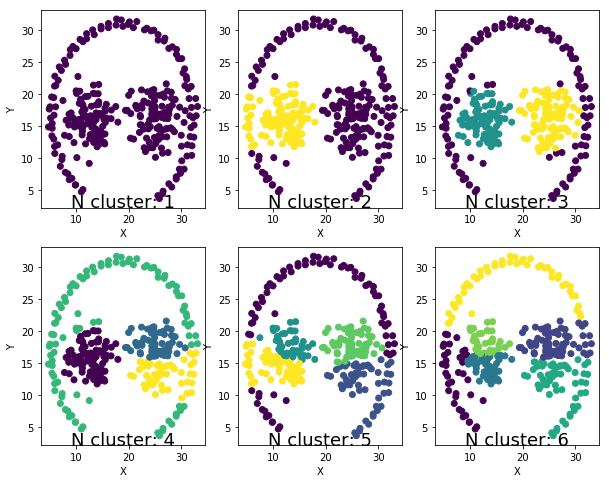

In [33]:
#3d - the above clustering error in the plots are per data point. 
# Interestingly, normalization does not change things dramatically once sigma 
#is rescaled, and will therefore be neglected in our analysis henceforth.

# we would be tempted to say that we do see an elbow in "pathbased" around N=2-3!
#below here we show the clustering results for different cluster values

nm_dts = "pathbased"
XX = set_dataframes[nm_dts].as_matrix(columns=["X","Y"])

plt.figure(num=4,figsize=(10,8))
for i in range(1, 7):
    plt.subplot(2, 3, i) 
    label_loc_norm = KKM_norm_labels[nm_dts][-1][0][i]
    ax = plt.scatter(XX[:,0], XX[:,1], c=label_loc_norm)
    loc_ax = np.array(plt.axis())
    plt.text(np.mean(loc_ax[:2]),loc_ax[2], "N cluster: %d"%(i),
             fontsize=18, ha='center')    
    plt.xlabel("X")
    plt.ylabel("Y")